<a href="https://colab.research.google.com/github/ester0926/Deep-Generative-Models/blob/main/%E4%BD%9C%E6%A5%AD4_%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2025-10-25 15:03:41--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.250.107.101, 142.250.107.139, 142.250.107.102, ...
Connecting to drive.google.com (drive.google.com)|142.250.107.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-10-25 15:03:42--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.199.132, 2607:f8b0:400e:c02::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.199.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  --.-KB/s    in 0.1s    

2025-10-25 15

In [ ]:
# 安裝必要套件
!pip install yfinance ta -q

# 匯入基本套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# PyTorch 相關
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# 技術指標計算
import ta

# Sklearn 相關
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 設定隨機種子
import random
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 設定 device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用裝置: {device}')

  Preparing metadata (setup.py) ... done
使用裝置: cuda


In [ ]:
# 資料下載與技術指標計算
def download_and_prepare_data(ticker='2330.TW', start='2020-01-01', end='2024-12-31'):
    """
    下載股價資料並計算技術指標
    """
    # 下載資料
    print(f'下載 {ticker} 資料...')
    df = yf.download(ticker, start=start, end=end)

    # 確保資料完整
    df = df.dropna()

    # 計算技術指標
    print('計算技術指標...')

    # 趨勢型指標 - 移動平均線
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_20'] = df['Close'].rolling(window=20).mean()

    # 震盪型指標 - RSI
    def calculate_rsi(prices, period=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    df['RSI_14'] = calculate_rsi(df['Close'], period=14)

    # 波動型指標 - MACD
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['MACD_SIGNAL'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_HIST'] = df['MACD'] - df['MACD_SIGNAL']

    # 計算 log return (目標變數)
    df['logret'] = np.log(df['Close']).diff()

    # 移除 NaN
    df = df.dropna()

    print(f'資料形狀: {df.shape}')
    print(f'資料期間: {df.index[0]} 到 {df.index[-1]}')
    print(f'\n欄位名稱:')
    print(df.columns.tolist())

    # 顯示統計摘要
    print(f'\n前5筆資料:')
    print(df[['Close', 'SMA_5', 'SMA_20', 'RSI_14', 'MACD', 'MACD_SIGNAL', 'MACD_HIST', 'logret']].head())

    return df

# 下載資料
df = download_and_prepare_data('2330.TW')

[*********************100%***********************]  1 of 1 completed

下載 2330.TW 資料...
計算技術指標...
資料形狀: (1195, 12)
資料期間: 2020-02-07 00:00:00 到 2024-12-30 00:00:00

欄位名稱:
[('Close', '2330.TW'), ('High', '2330.TW'), ('Low', '2330.TW'), ('Open', '2330.TW'), ('Volume', '2330.TW'), ('SMA_5', ''), ('SMA_20', ''), ('RSI_14', ''), ('MACD', ''), ('MACD_SIGNAL', ''), ('MACD_HIST', ''), ('logret', '')]

前5筆資料:
Price            Close       SMA_5      SMA_20     RSI_14      MACD  \
Ticker         2330.TW                                                
Date                                                                  
2020-02-07  291.573517  289.440063  295.084860  43.065701 -2.860285   
2020-02-10  291.128998  291.662415  294.573717  41.044720 -2.735996   
2020-02-11  294.684845  292.818036  294.218138  42.753655 -2.323782   
2020-02-12  297.796173  294.151471  294.351483  41.911886 -1.726144   
2020-02-13  297.796173  294.595941  294.595941  45.967762 -1.238237   

Price      MACD_SIGNAL MACD_HIST    logret  
Ticker                                      
Date     

In [ ]:
# 資料集類別定義
class StockDataset(Dataset):
    """
    時間序列資料集
    """
    def __init__(self, data, lookback=30):
        self.data = torch.FloatTensor(data)
        self.lookback = lookback

    def __len__(self):
        return len(self.data) - self.lookback

    def __getitem__(self, idx):
        # 輸入: lookback 天的特徵
        x = self.data[idx:idx+self.lookback, :-1]  # 除了最後一欄(目標)
        # 輸出: 下一天的 log return
        y = self.data[idx+self.lookback, -1]  # 最後一欄是 logret
        return x, y

def prepare_datasets(df, lookback=30, train_ratio=0.8, val_ratio=0.1):
    """
    準備訓練、驗證、測試資料集
    嚴格的時間切分，避免資料洩漏
    """
    # 選擇特徵欄位（只用預設的6個技術指標）
    feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume',
                    'SMA_5', 'SMA_20', 'RSI_14',
                    'MACD', 'MACD_SIGNAL', 'MACD_HIST']
    target_col = 'logret'

    # 準備資料
    data = df[feature_cols + [target_col]].values

    # 時間序列切分 (8:1:1)
    n = len(data)
    train_size = int(n * train_ratio)
    val_size = int(n * val_ratio)

    train_data = data[:train_size]
    val_data = data[train_size:train_size+val_size]
    test_data = data[train_size+val_size:]

    print(f"資料切分:")
    print(f"  訓練集原始資料: {len(train_data)} 筆")
    print(f"  驗證集原始資料: {len(val_data)} 筆")
    print(f"  測試集原始資料: {len(test_data)} 筆")

    # 標準化 (只用訓練集 fit)
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # 分離特徵和目標
    train_X = train_data[:, :-1]
    train_y = train_data[:, -1:]

    # Fit scaler
    scaler_X.fit(train_X)
    scaler_y.fit(train_y)

    # 標準化所有資料
    def normalize_data(data, scaler_X, scaler_y):
        X = data[:, :-1]
        y = data[:, -1:]
        X_scaled = scaler_X.transform(X)
        y_scaled = scaler_y.transform(y)
        return np.concatenate([X_scaled, y_scaled], axis=1)

    train_scaled = normalize_data(train_data, scaler_X, scaler_y)
    val_scaled = normalize_data(val_data, scaler_X, scaler_y)
    test_scaled = normalize_data(test_data, scaler_X, scaler_y)

    # 建立 Dataset
    train_dataset = StockDataset(train_scaled, lookback)
    val_dataset = StockDataset(val_scaled, lookback)
    test_dataset = StockDataset(test_scaled, lookback)

    # 關鍵修正：保存測試集的原始收盤價
    # 測試集從 train_size+val_size 開始
    # Dataset 會用前 lookback 天作為第一個樣本的輸入
    # 所以第 i 個樣本對應的是 test_data[i+lookback] 的 logret
    # 要計算價格，我們需要 test_data[i+lookback-1] 的 Close（當天）和 test_data[i+lookback] 的 Close（下一天）

    test_start_idx = train_size + val_size

    # 從 df 中提取測試集對應的收盤價
    # 包含足夠的歷史數據來計算所有測試樣本的價格
    test_close_prices = df['Close'].values[test_start_idx:]

    print(f"\n測試集資訊:")
    print(f"  測試集開始索引: {test_start_idx}")
    print(f"  測試集收盤價數量: {len(test_close_prices)}")
    print(f"  測試樣本數: {len(test_dataset)}")
    print(f"  關係: 測試樣本數 = 測試集收盤價數量 - lookback = {len(test_close_prices)} - {lookback} = {len(test_dataset)}")

    # 儲存一些資訊用於後續分析
    info = {
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'feature_cols': feature_cols,
        'train_size': len(train_dataset),
        'val_size': len(val_dataset),
        'test_size': len(test_dataset),
        'n_features': len(feature_cols),
        'test_dates': df.index[test_start_idx+lookback:],  # 對應每個預測的日期
        'test_close_prices': test_close_prices,  # 包含所有測試期間的收盤價
        'lookback': lookback
    }

    return train_dataset, val_dataset, test_dataset, info

# 準備資料
lookback = 30
train_dataset, val_dataset, test_dataset, data_info = prepare_datasets(df, lookback=lookback)

print(f"\n最終統計:")
print(f"訓練集大小: {data_info['train_size']}")
print(f"驗證集大小: {data_info['val_size']}")
print(f"測試集大小: {data_info['test_size']}")
print(f"特徵數量: {data_info['n_features']}")
print(f"特徵列表: {data_info['feature_cols']}")

資料切分:
  訓練集原始資料: 956 筆
  驗證集原始資料: 119 筆
  測試集原始資料: 120 筆

測試集資訊:
  測試集開始索引: 1075
  測試集收盤價數量: 120
  測試樣本數: 90
  關係: 測試樣本數 = 測試集收盤價數量 - lookback = 120 - 30 = 90

最終統計:
訓練集大小: 926
驗證集大小: 89
測試集大小: 90
特徵數量: 11
特徵列表: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'SMA_20', 'RSI_14', 'MACD', 'MACD_SIGNAL', 'MACD_HIST']


In [ ]:
# LSTM 模型定義
class LSTMModel(nn.Module):
    """
    LSTM 基線模型
    """
    def __init__(self, input_size, hidden_size=128, dropout=0.1):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=dropout if dropout > 0 else 0
        )

        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        lstm_out, (h_n, c_n) = self.lstm(x)

        # 取最後一個時間步的輸出
        last_output = lstm_out[:, -1, :]  # (batch, hidden_size)

        # Layer Norm
        normed = self.layer_norm(last_output)

        # Dropout
        dropped = self.dropout(normed)

        # 預測
        output = self.fc(dropped)  # (batch, 1)

        return output.squeeze(-1)

# 建立 LSTM 模型
lstm_model = LSTMModel(
    input_size=data_info['n_features'],
    hidden_size=128,
    dropout=0.1
).to(device)

print(lstm_model)
print(f"\n總參數量: {sum(p.numel() for p in lstm_model.parameters()):,}")

LSTMModel(
  (lstm): LSTM(11, 128, batch_first=True, dropout=0.1)
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

總參數量: 72,577


In [ ]:
# Transformer 模型定義
class PositionalEncoding(nn.Module):
    """
    正弦位置編碼
    """
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                            (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        return x + self.pe[:, :x.size(1), :]


class TransformerModel(nn.Module):
    """
    Transformer Encoder-only 模型
    """
    def __init__(self, input_size, d_model=128, nhead=4, num_layers=2,
                 dim_feedforward=256, dropout=0.1):
        super(TransformerModel, self).__init__()

        # Input projection
        self.input_projection = nn.Linear(input_size, d_model)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)

        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        # Output layer
        self.fc = nn.Linear(d_model, 1)

        self.d_model = d_model

    def forward(self, x, return_attention=False):
        # x: (batch, seq_len, input_size)

        # Input projection
        x = self.input_projection(x)  # (batch, seq_len, d_model)

        # Positional encoding
        x = self.pos_encoder(x)

        # Transformer encoding
        if return_attention:
            # 手動獲取最後一層的注意力權重
            for i, layer in enumerate(self.transformer_encoder.layers):
                if i == len(self.transformer_encoder.layers) - 1:
                    # 最後一層，需要注意力權重
                    x = layer.self_attn(x, x, x, need_weights=True)[0] + x
                    attn_weights = layer.self_attn(x, x, x, need_weights=True)[1]
                    x = layer.norm1(x)
                    x = layer.linear2(layer.dropout(layer.activation(layer.linear1(x)))) + x
                    x = layer.norm2(x)
                else:
                    x = layer(x)
        else:
            x = self.transformer_encoder(x)
            attn_weights = None

        # Mean pooling over time dimension
        x = x.mean(dim=1)  # (batch, d_model)

        # Final prediction
        output = self.fc(x)  # (batch, 1)

        if return_attention:
            return output.squeeze(-1), attn_weights
        else:
            return output.squeeze(-1)

# 建立 Transformer 模型
transformer_model = TransformerModel(
    input_size=data_info['n_features'],
    d_model=128,
    nhead=4,
    num_layers=2,
    dim_feedforward=256,
    dropout=0.1
).to(device)

print(transformer_model)
print(f"\n總參數量: {sum(p.numel() for p in transformer_model.parameters()):,}")

TransformerModel(
  (input_projection): Linear(in_features=11, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

總參數量: 266,625


In [ ]:
# 訓練函數
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    訓練一個 epoch
    """
    model.train()
    total_loss = 0

    for batch_x, batch_y in dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        # Forward
        output = model(batch_x)
        loss = criterion(output, batch_y)

        # Backward
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device):
    """
    評估模型
    """
    model.eval()
    total_loss = 0
    predictions = []
    targets = []

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            output = model(batch_x)
            loss = criterion(output, batch_y)

            total_loss += loss.item()
            predictions.extend(output.cpu().numpy())
            targets.extend(batch_y.cpu().numpy())

    predictions = np.array(predictions)
    targets = np.array(targets)

    # 計算指標
    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    rmse = np.sqrt(mse)

    return total_loss / len(dataloader), predictions, targets, {'mse': mse, 'mae': mae, 'rmse': rmse}


def train_model(model, train_loader, val_loader, epochs, optimizer, scheduler, criterion, device, model_name):
    """
    完整訓練流程
    """
    best_val_loss = float('inf')
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_rmse': []
    }

    for epoch in range(epochs):
        # 訓練
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)

        # 驗證
        val_loss, _, _, val_metrics = evaluate(model, val_loader, criterion, device)

        # 更新學習率
        if scheduler is not None:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        # 記錄
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_rmse'].append(val_metrics['rmse'])

        # 印出進度
        if (epoch + 1) % 5 == 0:
            print(f"{model_name} Epoch [{epoch+1}/{epochs}] "
                  f"Train Loss: {train_loss:.6f} | "
                  f"Val Loss: {val_loss:.6f} | "
                  f"Val RMSE: {val_metrics['rmse']:.6f}")

        # 儲存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()

    # 載入最佳模型
    model.load_state_dict(best_model_state)

    return model, history

In [ ]:
# 訓練 LSTM 模型
# 建立 DataLoader
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 訓練 LSTM
print("=" * 50)
print("訓練 LSTM 模型")
print("=" * 50)

lstm_model = LSTMModel(
    input_size=data_info['n_features'],
    hidden_size=128,
    dropout=0.1
).to(device)

criterion = nn.MSELoss()
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=1e-4)

# 訓練
lstm_model, lstm_history = train_model(
    model=lstm_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=30,
    optimizer=optimizer_lstm,
    scheduler=None,
    criterion=criterion,
    device=device,
    model_name="LSTM"
)

print("\nLSTM 訓練完成!")

訓練 LSTM 模型
LSTM Epoch [5/30] Train Loss: 1.018177 | Val Loss: 1.590937 | Val RMSE: 1.230961
LSTM Epoch [10/30] Train Loss: 1.049155 | Val Loss: 1.611689 | Val RMSE: 1.236515
LSTM Epoch [15/30] Train Loss: 1.009116 | Val Loss: 1.699196 | Val RMSE: 1.266803
LSTM Epoch [20/30] Train Loss: 0.944141 | Val Loss: 1.665633 | Val RMSE: 1.251865
LSTM Epoch [25/30] Train Loss: 0.963037 | Val Loss: 1.701552 | Val RMSE: 1.263922
LSTM Epoch [30/30] Train Loss: 0.959067 | Val Loss: 1.683167 | Val RMSE: 1.255759

LSTM 訓練完成!


In [ ]:
# 訓練 Transformer 模型
print("=" * 50)
print("訓練 Transformer 模型")
print("=" * 50)

transformer_model = TransformerModel(
    input_size=data_info['n_features'],
    d_model=128,
    nhead=4,
    num_layers=2,
    dim_feedforward=256,
    dropout=0.1
).to(device)

criterion = nn.MSELoss()
optimizer_transformer = optim.AdamW(
    transformer_model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

# Warmup + CosineAnnealing
warmup_epochs = 3
total_epochs = 30

def get_lr_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        else:
            return 1.0

    warmup_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    cosine_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=1
    )

    return warmup_scheduler, cosine_scheduler

warmup_scheduler, cosine_scheduler = get_lr_scheduler(
    optimizer_transformer, warmup_epochs, total_epochs
)

# 自定義訓練迴圈來處理複雜的 scheduler
best_val_loss = float('inf')
transformer_history = {
    'train_loss': [],
    'val_loss': [],
    'val_rmse': []
}

for epoch in range(total_epochs):
    # 訓練
    train_loss = train_epoch(transformer_model, train_loader, criterion,
                            optimizer_transformer, device)

    # 驗證
    val_loss, _, _, val_metrics = evaluate(transformer_model, val_loader,
                                          criterion, device)

    # 更新學習率
    if epoch < warmup_epochs:
        warmup_scheduler.step()
    else:
        cosine_scheduler.step()

    # 記錄
    transformer_history['train_loss'].append(train_loss)
    transformer_history['val_loss'].append(val_loss)
    transformer_history['val_rmse'].append(val_metrics['rmse'])

    # 印出進度
    if (epoch + 1) % 5 == 0:
        print(f"Transformer Epoch [{epoch+1}/{total_epochs}] "
              f"Train Loss: {train_loss:.6f} | "
              f"Val Loss: {val_loss:.6f} | "
              f"Val RMSE: {val_metrics['rmse']:.6f}")

    # 儲存最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_transformer_state = transformer_model.state_dict().copy()

# 載入最佳模型
transformer_model.load_state_dict(best_transformer_state)

print("\nTransformer 訓練完成!")

訓練 Transformer 模型
Transformer Epoch [5/30] Train Loss: 0.935155 | Val Loss: 1.566594 | Val RMSE: 1.222452
Transformer Epoch [10/30] Train Loss: 0.938991 | Val Loss: 1.705441 | Val RMSE: 1.269166
Transformer Epoch [15/30] Train Loss: 0.930960 | Val Loss: 1.784171 | Val RMSE: 1.292825
Transformer Epoch [20/30] Train Loss: 0.930980 | Val Loss: 2.053917 | Val RMSE: 1.375164
Transformer Epoch [25/30] Train Loss: 0.985594 | Val Loss: 2.462407 | Val RMSE: 1.502483
Transformer Epoch [30/30] Train Loss: 0.900969 | Val Loss: 2.749127 | Val RMSE: 1.580717

Transformer 訓練完成!


In [ ]:
# 測試集評估
def evaluate_on_test(model, test_loader, data_info, device, model_name):
    """
    在測試集上評估模型，計算兩種尺度的指標
    """
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            output = model(batch_x)
            predictions.extend(output.cpu().numpy())
            targets.extend(batch_y.cpu().numpy())

    predictions = np.array(predictions)
    targets = np.array(targets)

    # 1. 標準化空間的指標
    mse_std = mean_squared_error(targets, predictions)
    mae_std = mean_absolute_error(targets, predictions)
    rmse_std = np.sqrt(mse_std)

    # 2. 反標準化到原始尺度
    scaler_y = data_info['scaler_y']
    predictions_original = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
    targets_original = scaler_y.inverse_transform(targets.reshape(-1, 1)).flatten()

    mse_original = mean_squared_error(targets_original, predictions_original)
    mae_original = mean_absolute_error(targets_original, predictions_original)
    rmse_original = np.sqrt(mse_original)

    # 3. 將 log return 轉換回價格尺度
    test_close_prices = data_info['test_close_prices']
    lookback = data_info['lookback']
    n_predictions = len(predictions_original)

    # 確保 test_close_prices 是一維陣列
    test_close_prices = np.asarray(test_close_prices).flatten()

    # 第 i 個預測對應：
    # - 當天價格: test_close_prices[lookback + i - 1]
    # - 下一天價格: test_close_prices[lookback + i]

    base_prices = test_close_prices[lookback-1:lookback-1+n_predictions]
    true_prices = test_close_prices[lookback:lookback+n_predictions]

    # 確保都是一維陣列
    base_prices = base_prices.flatten()
    true_prices = true_prices.flatten()
    predictions_original = predictions_original.flatten()

    # 計算預測價格
    pred_prices = base_prices * np.exp(predictions_original)

    print(f"\n{model_name} 評估:")
    print(f"  預測數量: {n_predictions}")
    print(f"  base_prices shape: {base_prices.shape}")
    print(f"  true_prices shape: {true_prices.shape}")
    print(f"  predictions_original shape: {predictions_original.shape}")
    print(f"  pred_prices shape: {pred_prices.shape}")

    mse_price = mean_squared_error(true_prices, pred_prices)
    mae_price = mean_absolute_error(true_prices, pred_prices)
    rmse_price = np.sqrt(mse_price)

    results = {
        'model_name': model_name,
        'standardized': {
            'mse': mse_std,
            'mae': mae_std,
            'rmse': rmse_std
        },
        'original': {
            'mse': mse_original,
            'mae': mae_original,
            'rmse': rmse_original
        },
        'price': {
            'mse': mse_price,
            'mae': mae_price,
            'rmse': rmse_price
        },
        'predictions_std': predictions,
        'targets_std': targets,
        'predictions_logret': predictions_original,
        'targets_logret': targets_original,
        'predictions_price': pred_prices,
        'targets_price': true_prices
    }

    return results

# 評估兩個模型
print("=" * 50)
print("測試集評估")
print("=" * 50)

lstm_results = evaluate_on_test(lstm_model, test_loader, data_info, device, "LSTM")
transformer_results = evaluate_on_test(transformer_model, test_loader, data_info, device, "Transformer")

# 顯示結果
def print_results(results):
    print(f"\n{'=' * 50}")
    print(f"{results['model_name']} TEST 結果")
    print('=' * 50)
    print(f"標準化空間:")
    print(f"  MSE  = {results['standardized']['mse']:.6f}")
    print(f"  MAE  = {results['standardized']['mae']:.6f}")
    print(f"  RMSE = {results['standardized']['rmse']:.6f}")

    print(f"\n原始 logret 尺度:")
    print(f"  MSE  = {results['original']['mse']:.6f}")
    print(f"  MAE  = {results['original']['mae']:.6f}")
    print(f"  RMSE = {results['original']['rmse']:.6f}")

    print(f"\n價格尺度:")
    print(f"  MSE  = {results['price']['mse']:.2f}")
    print(f"  MAE  = {results['price']['mae']:.2f}")
    print(f"  RMSE = {results['price']['rmse']:.2f}")

print_results(lstm_results)
print_results(transformer_results)

測試集評估

LSTM 評估:
  預測數量: 90
  base_prices shape: (90,)
  true_prices shape: (90,)
  predictions_original shape: (90,)
  pred_prices shape: (90,)

Transformer 評估:
  預測數量: 90
  base_prices shape: (90,)
  true_prices shape: (90,)
  predictions_original shape: (90,)
  pred_prices shape: (90,)

LSTM TEST 結果
標準化空間:
  MSE  = 1.313485
  MAE  = 0.876782
  RMSE = 1.146074

原始 logret 尺度:
  MSE  = 0.000390
  MAE  = 0.015100
  RMSE = 0.019737

價格尺度:
  MSE  = 381.82
  MAE  = 14.98
  RMSE = 19.54

Transformer TEST 結果
標準化空間:
  MSE  = 2.362825
  MAE  = 1.279282
  RMSE = 1.537148

原始 logret 尺度:
  MSE  = 0.000701
  MAE  = 0.022031
  RMSE = 0.026472

價格尺度:
  MSE  = 685.96
  MAE  = 21.79
  RMSE = 26.19


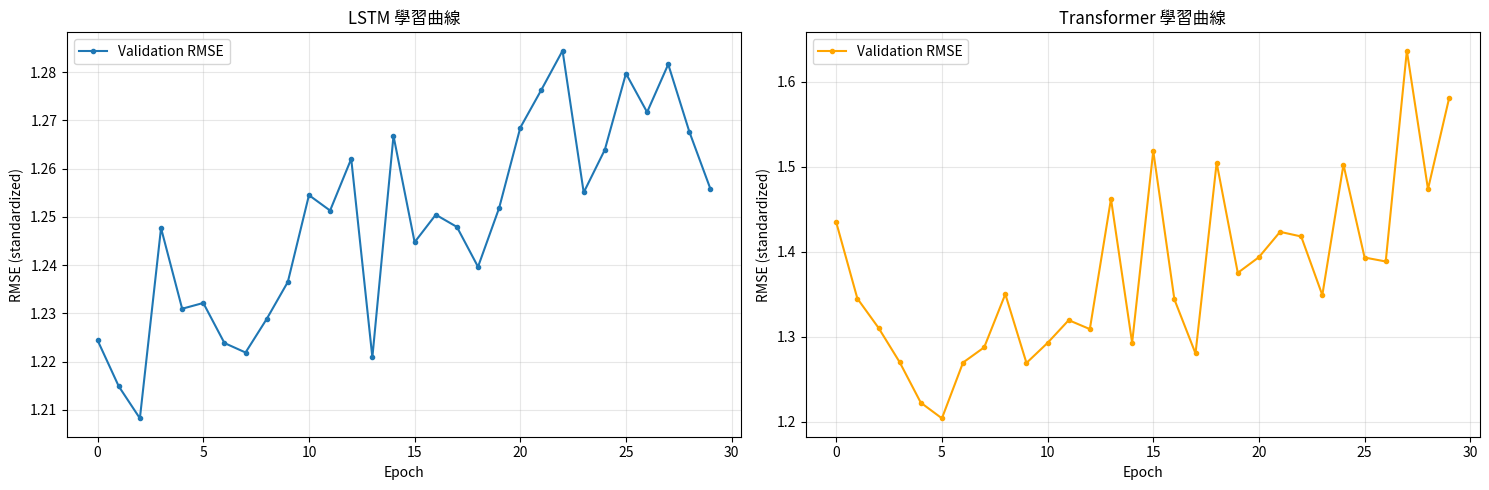

In [ ]:
# 繪製學習曲線
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# LSTM 學習曲線
axes[0].plot(lstm_history['val_rmse'], label='Validation RMSE', marker='o', markersize=3)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('RMSE (standardized)')
axes[0].set_title('LSTM 學習曲線')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Transformer 學習曲線
axes[1].plot(transformer_history['val_rmse'], label='Validation RMSE', marker='o', markersize=3, color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('RMSE (standardized)')
axes[1].set_title('Transformer 學習曲線')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

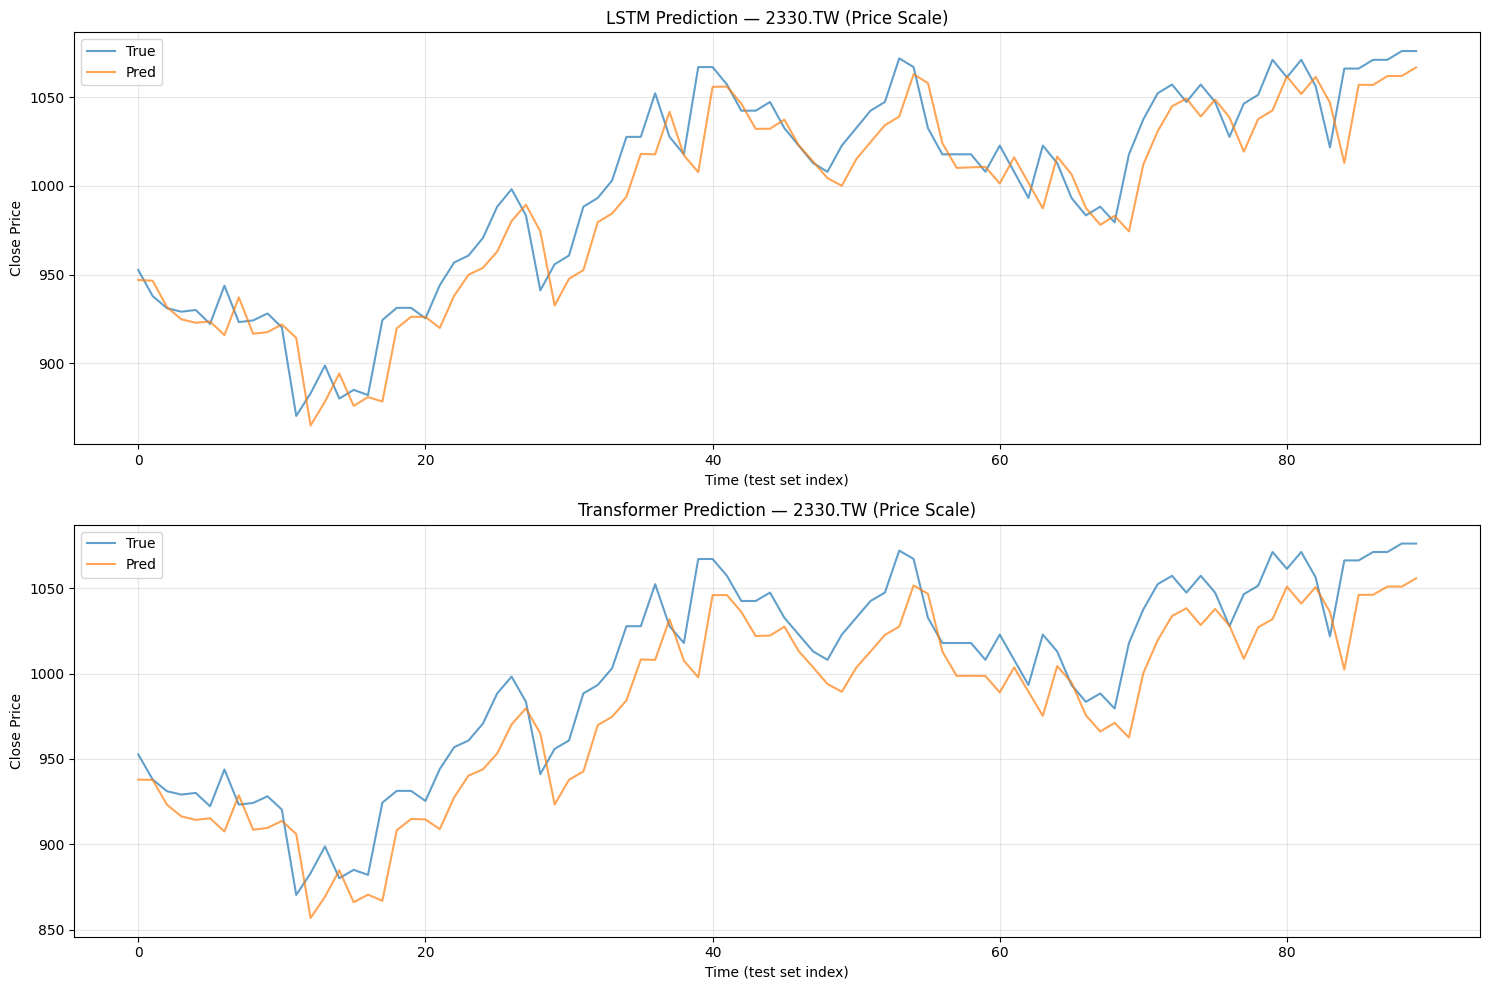

In [ ]:
# 繪製預測結果 (價格尺度)
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# LSTM 預測
axes[0].plot(lstm_results['targets_price'], label='True', alpha=0.7, linewidth=1.5)
axes[0].plot(lstm_results['predictions_price'], label='Pred', alpha=0.7, linewidth=1.5)
axes[0].set_xlabel('Time (test set index)')
axes[0].set_ylabel('Close Price')
axes[0].set_title('LSTM Prediction — 2330.TW (Price Scale)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Transformer 預測
axes[1].plot(transformer_results['targets_price'], label='True', alpha=0.7, linewidth=1.5)
axes[1].plot(transformer_results['predictions_price'], label='Pred', alpha=0.7, linewidth=1.5)
axes[1].set_xlabel('Time (test set index)')
axes[1].set_ylabel('Close Price')
axes[1].set_title('Transformer Prediction — 2330.TW (Price Scale)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

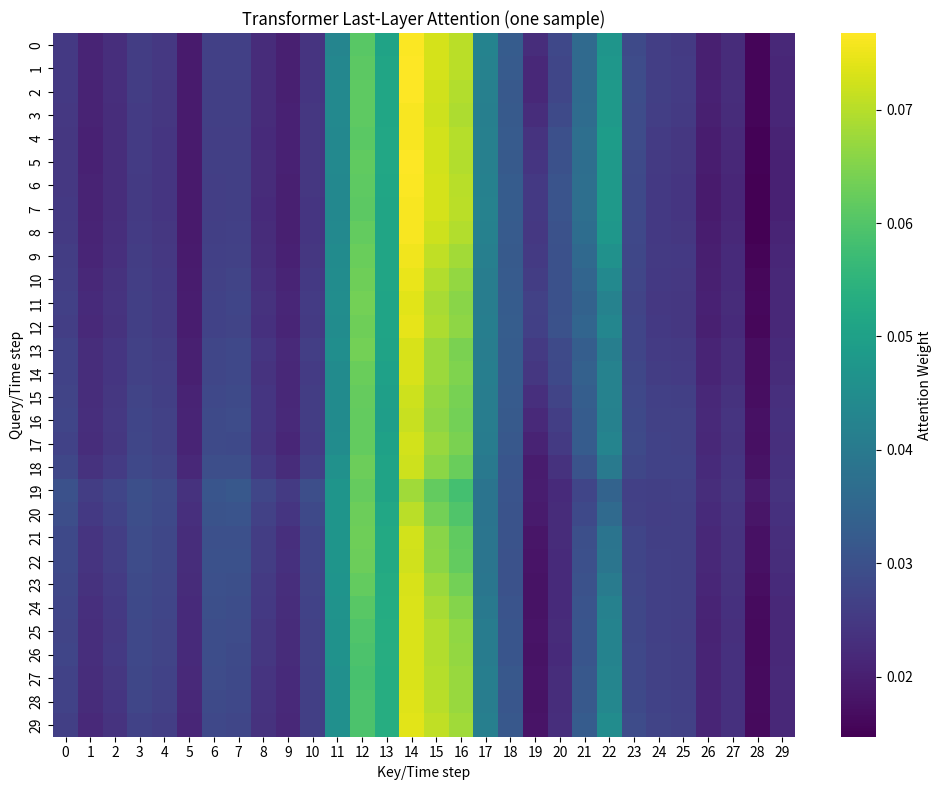

Attention map shape: (30, 30)
注意力權重總和 (每一行): [1.         0.99999994 1.         1.0000001  1.        ]...


In [ ]:
# 提取並視覺化 Attention Heatmap
def get_attention_map(model, sample_x, device):
    """
    獲取 Transformer 最後一層的 attention 權重
    """
    model.eval()

    # 需要修改 forward 來返回 attention
    with torch.no_grad():
        sample_x = sample_x.unsqueeze(0).to(device)  # (1, seq_len, features)

        # 手動執行 forward 並獲取注意力
        x = model.input_projection(sample_x)
        x = model.pos_encoder(x)

        # 獲取最後一層的注意力權重
        for i, layer in enumerate(model.transformer_encoder.layers):
            if i == len(model.transformer_encoder.layers) - 1:
                # 最後一層
                attn_output, attn_weights = layer.self_attn(x, x, x, need_weights=True)
                # attn_weights: (batch, seq_len, seq_len)
                break
            else:
                x = layer(x)

    return attn_weights.squeeze(0).cpu().numpy()  # (seq_len, seq_len)

# 獲取一個測試樣本
sample_idx = 0
sample_x, sample_y = test_dataset[sample_idx]

# 獲取 attention map
attention_map = get_attention_map(transformer_model, sample_x, device)

# 視覺化
plt.figure(figsize=(10, 8))
sns.heatmap(attention_map, cmap='viridis', cbar_kws={'label': 'Attention Weight'})
plt.xlabel('Key/Time step')
plt.ylabel('Query/Time step')
plt.title('Transformer Last-Layer Attention (one sample)')
plt.tight_layout()
plt.show()

print(f"Attention map shape: {attention_map.shape}")
print(f"注意力權重總和 (每一行): {attention_map.sum(axis=1)[:5]}...")  # 應該接近 1

In [ ]:
# 技術指標分組實驗
def experiment_with_indicators(df, indicator_groups, lookback=30):
    """
    實驗不同技術指標組合的效果
    """
    results_summary = []

    for group_name, indicators in indicator_groups.items():
        print(f"\n{'='*50}")
        print(f"實驗指標組: {group_name}")
        print(f"指標: {indicators}")
        print('='*50)

        # 準備資料
        base_features = ['Open', 'High', 'Low', 'Close', 'Volume']
        feature_cols = base_features + indicators
        target_col = 'logret'

        # 確保所有欄位都存在
        available_cols = [col for col in feature_cols if col in df.columns]
        if len(available_cols) != len(feature_cols):
            missing = set(feature_cols) - set(available_cols)
            print(f"警告: 缺少欄位 {missing}，跳過此組")
            continue

        data = df[feature_cols + [target_col]].values

        # 切分資料
        n = len(data)
        train_size = int(n * 0.8)
        val_size = int(n * 0.1)

        train_data = data[:train_size]
        test_data = data[train_size+val_size:]

        # 標準化
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

        train_X = train_data[:, :-1]
        train_y = train_data[:, -1:]

        scaler_X.fit(train_X)
        scaler_y.fit(train_y)

        def normalize_data(data, scaler_X, scaler_y):
            X = data[:, :-1]
            y = data[:, -1:]
            X_scaled = scaler_X.transform(X)
            y_scaled = scaler_y.transform(y)
            return np.concatenate([X_scaled, y_scaled], axis=1)

        train_scaled = normalize_data(train_data, scaler_X, scaler_y)
        test_scaled = normalize_data(test_data, scaler_X, scaler_y)

        # 建立資料集
        train_ds = StockDataset(train_scaled, lookback)
        test_ds = StockDataset(test_scaled, lookback)

        train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

        print(f"訓練樣本數: {len(train_ds)}, 測試樣本數: {len(test_ds)}")

        # 訓練簡單的 LSTM 模型
        model = LSTMModel(
            input_size=len(feature_cols),
            hidden_size=64,
            dropout=0.1
        ).to(device)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        # 快速訓練 15 epochs
        print("開始訓練...")
        for epoch in range(15):
            train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
            if (epoch + 1) % 5 == 0:
                print(f"  Epoch {epoch+1}/15 - Loss: {train_loss:.6f}")

        # 評估
        model.eval()
        predictions = []
        targets = []

        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x = batch_x.to(device)
                output = model(batch_x)
                predictions.extend(output.cpu().numpy())
                targets.extend(batch_y.cpu().numpy())

        predictions = np.array(predictions)
        targets = np.array(targets)

        # 計算標準化空間的指標
        rmse = np.sqrt(mean_squared_error(targets, predictions))
        mae = mean_absolute_error(targets, predictions)

        # 反標準化計算原始尺度指標
        predictions_original = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
        targets_original = scaler_y.inverse_transform(targets.reshape(-1, 1)).flatten()

        rmse_original = np.sqrt(mean_squared_error(targets_original, predictions_original))
        mae_original = mean_absolute_error(targets_original, predictions_original)

        results_summary.append({
            'Group': group_name,
            'Indicators': ', '.join(indicators),
            'N_Features': len(feature_cols),
            'RMSE_std': rmse,
            'MAE_std': mae,
            'RMSE_original': rmse_original,
            'MAE_original': mae_original
        })

        print(f"結果: RMSE(std)={rmse:.6f}, MAE(std)={mae:.6f}")
        print(f"      RMSE(orig)={rmse_original:.6f}, MAE(orig)={mae_original:.6f}")

    return pd.DataFrame(results_summary)

# 定義四類技術指標組合
indicator_groups = {
    '基準 (Base)': [],  # 只用基本價量資料
    '趨勢型 (Trend)': ['SMA_5', 'SMA_20'],
    '震盪型 (Oscillator)': ['RSI_14'],
    '波動型 (Volatility)': ['MACD', 'MACD_SIGNAL', 'MACD_HIST'],
    '全部指標 (All)': ['SMA_5', 'SMA_20', 'RSI_14', 'MACD', 'MACD_SIGNAL', 'MACD_HIST']
}

# 執行實驗
print("=" * 60)
print("技術指標分組實驗")
print("=" * 60)

indicator_results = experiment_with_indicators(df, indicator_groups, lookback=30)

print("\n" + "=" * 60)
print("實驗結果總結")
print("=" * 60)
print(indicator_results.to_string(index=False))

技術指標分組實驗

實驗指標組: 基準 (Base)
指標: []
訓練樣本數: 926, 測試樣本數: 90
開始訓練...
  Epoch 5/15 - Loss: 0.994008
  Epoch 10/15 - Loss: 0.958679
  Epoch 15/15 - Loss: 0.988776
結果: RMSE(std)=1.176366, MAE(std)=0.897560
      RMSE(orig)=0.020259, MAE(orig)=0.015458

實驗指標組: 趨勢型 (Trend)
指標: ['SMA_5', 'SMA_20']
訓練樣本數: 926, 測試樣本數: 90
開始訓練...
  Epoch 5/15 - Loss: 0.975111
  Epoch 10/15 - Loss: 0.956817
  Epoch 15/15 - Loss: 0.991706
結果: RMSE(std)=1.085554, MAE(std)=0.830692
      RMSE(orig)=0.018695, MAE(orig)=0.014306

實驗指標組: 震盪型 (Oscillator)
指標: ['RSI_14']
訓練樣本數: 926, 測試樣本數: 90
開始訓練...
  Epoch 5/15 - Loss: 0.995790
  Epoch 10/15 - Loss: 0.979686
  Epoch 15/15 - Loss: 0.987900
結果: RMSE(std)=1.164692, MAE(std)=0.888562
      RMSE(orig)=0.020058, MAE(orig)=0.015303

實驗指標組: 波動型 (Volatility)
指標: ['MACD', 'MACD_SIGNAL', 'MACD_HIST']
訓練樣本數: 926, 測試樣本數: 90
開始訓練...
  Epoch 5/15 - Loss: 1.013850
  Epoch 10/15 - Loss: 1.006909
  Epoch 15/15 - Loss: 0.990326
結果: RMSE(std)=1.057663, MAE(std)=0.805282
      RMSE(orig)=0.018

In [ ]:
# 四類指標在 LSTM 與 Transformer 的比較實驗
def experiment_indicators_two_models(df, indicator_groups, lookback=30):
    """
    比較四類指標在 LSTM 和 Transformer 兩種模型中的效果
    """
    results_summary = []

    for group_name, indicators in indicator_groups.items():
        print(f"\n{'='*60}")
        print(f"實驗指標組: {group_name}")
        print(f"指標: {indicators if indicators else '無 (僅基本特徵)'}")
        print('='*60)

        # 準備資料
        base_features = ['Open', 'High', 'Low', 'Close', 'Volume']
        feature_cols = base_features + indicators
        target_col = 'logret'

        data = df[feature_cols + [target_col]].values

        # 切分資料
        n = len(data)
        train_size = int(n * 0.8)
        val_size = int(n * 0.1)

        train_data = data[:train_size]
        val_data = data[train_size:train_size+val_size]
        test_data = data[train_size+val_size:]

        # 標準化
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

        train_X = train_data[:, :-1]
        train_y = train_data[:, -1:]

        scaler_X.fit(train_X)
        scaler_y.fit(train_y)

        def normalize_data(data, scaler_X, scaler_y):
            X = data[:, :-1]
            y = data[:, -1:]
            X_scaled = scaler_X.transform(X)
            y_scaled = scaler_y.transform(y)
            return np.concatenate([X_scaled, y_scaled], axis=1)

        train_scaled = normalize_data(train_data, scaler_X, scaler_y)
        val_scaled = normalize_data(val_data, scaler_X, scaler_y)
        test_scaled = normalize_data(test_data, scaler_X, scaler_y)

        # 建立資料集
        train_ds = StockDataset(train_scaled, lookback)
        val_ds = StockDataset(val_scaled, lookback)
        test_ds = StockDataset(test_scaled, lookback)

        train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
        test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

        print(f"特徵數: {len(feature_cols)}, 訓練樣本: {len(train_ds)}, 測試樣本: {len(test_ds)}")

        # ============ 訓練 LSTM ============
        print("\n[1/2] 訓練 LSTM 模型...")
        lstm_model = LSTMModel(
            input_size=len(feature_cols),
            hidden_size=128,
            dropout=0.1
        ).to(device)

        criterion = nn.MSELoss()
        optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=1e-4)

        # 訓練 20 epochs
        for epoch in range(20):
            train_epoch(lstm_model, train_loader, criterion, optimizer_lstm, device)
            if (epoch + 1) % 10 == 0:
                _, _, _, val_metrics = evaluate(lstm_model, val_loader, criterion, device)
                print(f"  Epoch {epoch+1}/20 - Val RMSE: {val_metrics['rmse']:.6f}")

        # 評估 LSTM
        lstm_model.eval()
        lstm_predictions = []
        lstm_targets = []

        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x = batch_x.to(device)
                output = lstm_model(batch_x)
                lstm_predictions.extend(output.cpu().numpy())
                lstm_targets.extend(batch_y.cpu().numpy())

        lstm_predictions = np.array(lstm_predictions)
        lstm_targets = np.array(lstm_targets)

        lstm_rmse_std = np.sqrt(mean_squared_error(lstm_targets, lstm_predictions))
        lstm_mae_std = mean_absolute_error(lstm_targets, lstm_predictions)

        lstm_pred_orig = scaler_y.inverse_transform(lstm_predictions.reshape(-1, 1)).flatten()
        lstm_tgt_orig = scaler_y.inverse_transform(lstm_targets.reshape(-1, 1)).flatten()

        lstm_rmse_orig = np.sqrt(mean_squared_error(lstm_tgt_orig, lstm_pred_orig))
        lstm_mae_orig = mean_absolute_error(lstm_tgt_orig, lstm_pred_orig)

        print(f"  LSTM 結果 - RMSE: {lstm_rmse_std:.6f}, MAE: {lstm_mae_std:.6f}")

        # ============ 訓練 Transformer ============
        print("\n[2/2] 訓練 Transformer 模型...")
        transformer_model = TransformerModel(
            input_size=len(feature_cols),
            d_model=128,
            nhead=4,
            num_layers=2,
            dim_feedforward=256,
            dropout=0.1
        ).to(device)

        optimizer_trans = optim.AdamW(
            transformer_model.parameters(),
            lr=3e-4,
            weight_decay=1e-4
        )

        # 訓練 20 epochs (簡化版，不用複雜的 scheduler)
        for epoch in range(20):
            train_epoch(transformer_model, train_loader, criterion, optimizer_trans, device)
            if (epoch + 1) % 10 == 0:
                _, _, _, val_metrics = evaluate(transformer_model, val_loader, criterion, device)
                print(f"  Epoch {epoch+1}/20 - Val RMSE: {val_metrics['rmse']:.6f}")

        # 評估 Transformer
        transformer_model.eval()
        trans_predictions = []
        trans_targets = []

        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x = batch_x.to(device)
                output = transformer_model(batch_x)
                trans_predictions.extend(output.cpu().numpy())
                trans_targets.extend(batch_y.cpu().numpy())

        trans_predictions = np.array(trans_predictions)
        trans_targets = np.array(trans_targets)

        trans_rmse_std = np.sqrt(mean_squared_error(trans_targets, trans_predictions))
        trans_mae_std = mean_absolute_error(trans_targets, trans_predictions)

        trans_pred_orig = scaler_y.inverse_transform(trans_predictions.reshape(-1, 1)).flatten()
        trans_tgt_orig = scaler_y.inverse_transform(trans_targets.reshape(-1, 1)).flatten()

        trans_rmse_orig = np.sqrt(mean_squared_error(trans_tgt_orig, trans_pred_orig))
        trans_mae_orig = mean_absolute_error(trans_tgt_orig, trans_pred_orig)

        print(f"  Transformer 結果 - RMSE: {trans_rmse_std:.6f}, MAE: {trans_mae_std:.6f}")

        # 儲存結果
        results_summary.append({
            'Group': group_name,
            'Indicators': ', '.join(indicators) if indicators else 'None',
            'N_Features': len(feature_cols),
            'LSTM_RMSE_std': lstm_rmse_std,
            'LSTM_MAE_std': lstm_mae_std,
            'LSTM_RMSE_orig': lstm_rmse_orig,
            'LSTM_MAE_orig': lstm_mae_orig,
            'Trans_RMSE_std': trans_rmse_std,
            'Trans_MAE_std': trans_mae_std,
            'Trans_RMSE_orig': trans_rmse_orig,
            'Trans_MAE_orig': trans_mae_orig,
            'RMSE_Diff': trans_rmse_std - lstm_rmse_std,  # 負數表示 Transformer 更好
            'MAE_Diff': trans_mae_std - lstm_mae_std
        })

    return pd.DataFrame(results_summary)

# 定義四類技術指標組合
indicator_groups_comparison = {
    '基準 (Base)': [],
    '趨勢型 (Trend)': ['SMA_5', 'SMA_20'],
    '震盪型 (Oscillator)': ['RSI_14'],
    '波動型 (Volatility)': ['MACD', 'MACD_SIGNAL', 'MACD_HIST'],
    '全部指標 (All)': ['SMA_5', 'SMA_20', 'RSI_14', 'MACD', 'MACD_SIGNAL', 'MACD_HIST']
}

# 執行比較實驗
print("=" * 70)
print("四類指標在 LSTM vs Transformer 的比較實驗")
print("=" * 70)

comparison_results = experiment_indicators_two_models(df, indicator_groups_comparison, lookback=30)

print("\n" + "=" * 70)
print("實驗結果總表")
print("=" * 70)
print(comparison_results.to_string(index=False))

四類指標在 LSTM vs Transformer 的比較實驗

實驗指標組: 基準 (Base)
指標: 無 (僅基本特徵)
特徵數: 5, 訓練樣本: 926, 測試樣本: 90

[1/2] 訓練 LSTM 模型...
  Epoch 10/20 - Val RMSE: 1.177808
  Epoch 20/20 - Val RMSE: 1.194958
  LSTM 結果 - RMSE: 1.086673, MAE: 0.830104

[2/2] 訓練 Transformer 模型...
  Epoch 10/20 - Val RMSE: 1.201512
  Epoch 20/20 - Val RMSE: 1.250730
  Transformer 結果 - RMSE: 1.121377, MAE: 0.858744

實驗指標組: 趨勢型 (Trend)
指標: ['SMA_5', 'SMA_20']
特徵數: 7, 訓練樣本: 926, 測試樣本: 90

[1/2] 訓練 LSTM 模型...
  Epoch 10/20 - Val RMSE: 1.127212
  Epoch 20/20 - Val RMSE: 1.148310
  LSTM 結果 - RMSE: 1.025896, MAE: 0.771139

[2/2] 訓練 Transformer 模型...
  Epoch 10/20 - Val RMSE: 1.279880
  Epoch 20/20 - Val RMSE: 1.298045
  Transformer 結果 - RMSE: 1.184372, MAE: 0.905648

實驗指標組: 震盪型 (Oscillator)
指標: ['RSI_14']
特徵數: 6, 訓練樣本: 926, 測試樣本: 90

[1/2] 訓練 LSTM 模型...
  Epoch 10/20 - Val RMSE: 1.195546
  Epoch 20/20 - Val RMSE: 1.222313
  LSTM 結果 - RMSE: 1.098716, MAE: 0.840528

[2/2] 訓練 Transformer 模型...
  Epoch 10/20 - Val RMSE: 1.286814
  Epoch 20/2

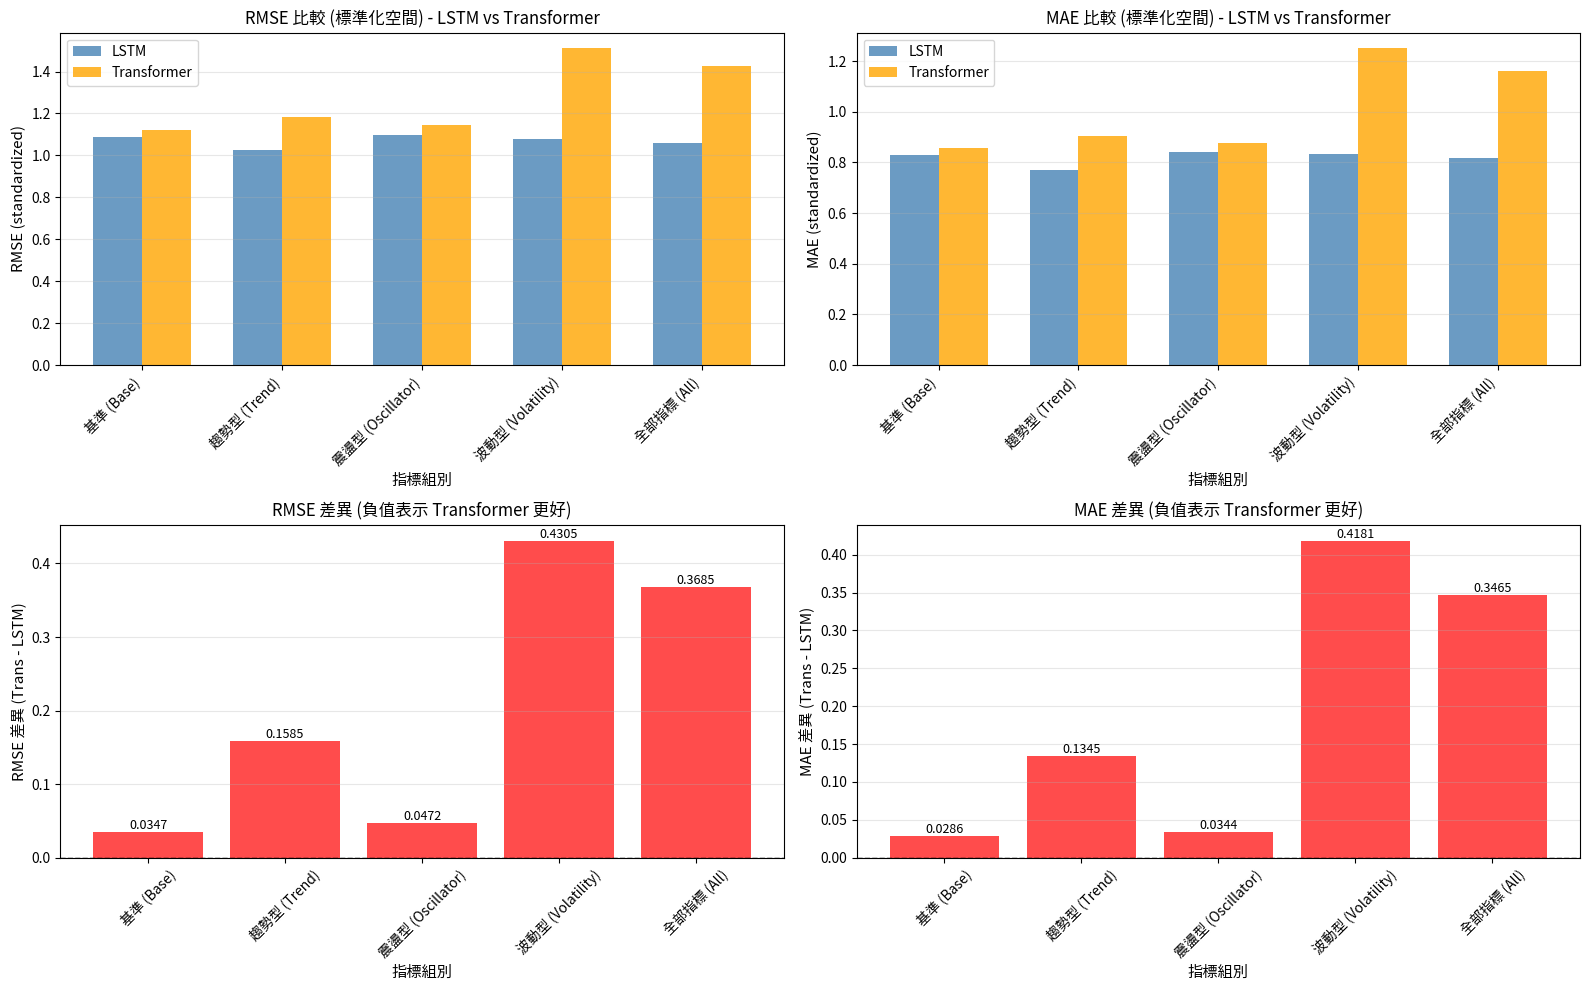


四類指標在 LSTM vs Transformer 的詳細分析

【基準 (Base)】
指標: None
特徵數: 5
----------------------------------------------------------------------
LSTM:
  RMSE (std):  1.086673
  MAE (std):   0.830104
  RMSE (orig): 0.018714

Transformer:
  RMSE (std):  1.121377
  MAE (std):   0.858744
  RMSE (orig): 0.019312

✓ LSTM 較佳，RMSE 改善 3.09%

【趨勢型 (Trend)】
指標: SMA_5, SMA_20
特徵數: 7
----------------------------------------------------------------------
LSTM:
  RMSE (std):  1.025896
  MAE (std):   0.771139
  RMSE (orig): 0.017668

Transformer:
  RMSE (std):  1.184372
  MAE (std):   0.905648
  RMSE (orig): 0.020397

✓ LSTM 較佳，RMSE 改善 13.38%

【震盪型 (Oscillator)】
指標: RSI_14
特徵數: 6
----------------------------------------------------------------------
LSTM:
  RMSE (std):  1.098716
  MAE (std):   0.840528
  RMSE (orig): 0.018922

Transformer:
  RMSE (std):  1.145872
  MAE (std):   0.874975
  RMSE (orig): 0.019734

✓ LSTM 較佳，RMSE 改善 4.12%

【波動型 (Volatility)】
指標: MACD, MACD_SIGNAL, MACD_HIST
特徵數: 8
-------------------

In [ ]:
# 視覺化四類指標在兩種模型的比較
# 視覺化四類指標在 LSTM 和 Transformer 的比較
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 準備資料
groups = comparison_results['Group']
x = np.arange(len(groups))
width = 0.35

# 1. RMSE (標準化) 比較
axes[0, 0].bar(x - width/2, comparison_results['LSTM_RMSE_std'], width,
               label='LSTM', color='steelblue', alpha=0.8)
axes[0, 0].bar(x + width/2, comparison_results['Trans_RMSE_std'], width,
               label='Transformer', color='orange', alpha=0.8)
axes[0, 0].set_xlabel('指標組別', fontsize=11)
axes[0, 0].set_ylabel('RMSE (standardized)', fontsize=11)
axes[0, 0].set_title('RMSE 比較 (標準化空間) - LSTM vs Transformer',
                     fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(groups, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. MAE (標準化) 比較
axes[0, 1].bar(x - width/2, comparison_results['LSTM_MAE_std'], width,
               label='LSTM', color='steelblue', alpha=0.8)
axes[0, 1].bar(x + width/2, comparison_results['Trans_MAE_std'], width,
               label='Transformer', color='orange', alpha=0.8)
axes[0, 1].set_xlabel('指標組別', fontsize=11)
axes[0, 1].set_ylabel('MAE (standardized)', fontsize=11)
axes[0, 1].set_title('MAE 比較 (標準化空間) - LSTM vs Transformer',
                     fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(groups, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. RMSE 差異 (Transformer - LSTM)
colors = ['green' if val < 0 else 'red' for val in comparison_results['RMSE_Diff']]
axes[1, 0].bar(groups, comparison_results['RMSE_Diff'], color=colors, alpha=0.7)
axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 0].set_xlabel('指標組別', fontsize=11)
axes[1, 0].set_ylabel('RMSE 差異 (Trans - LSTM)', fontsize=11)
axes[1, 0].set_title('RMSE 差異 (負值表示 Transformer 更好)',
                     fontsize=12, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_results['RMSE_Diff']):
    axes[1, 0].text(i, v, f'{v:.4f}', ha='center',
                    va='bottom' if v > 0 else 'top', fontsize=9)

# 4. MAE 差異 (Transformer - LSTM)
colors = ['green' if val < 0 else 'red' for val in comparison_results['MAE_Diff']]
axes[1, 1].bar(groups, comparison_results['MAE_Diff'], color=colors, alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 1].set_xlabel('指標組別', fontsize=11)
axes[1, 1].set_ylabel('MAE 差異 (Trans - LSTM)', fontsize=11)
axes[1, 1].set_title('MAE 差異 (負值表示 Transformer 更好)',
                     fontsize=12, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_results['MAE_Diff']):
    axes[1, 1].text(i, v, f'{v:.4f}', ha='center',
                    va='bottom' if v > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

# 詳細分析
print("\n" + "=" * 70)
print("四類指標在 LSTM vs Transformer 的詳細分析")
print("=" * 70)

for idx, row in comparison_results.iterrows():
    print(f"\n【{row['Group']}】")
    print(f"指標: {row['Indicators']}")
    print(f"特徵數: {row['N_Features']}")
    print("-" * 70)

    print(f"LSTM:")
    print(f"  RMSE (std):  {row['LSTM_RMSE_std']:.6f}")
    print(f"  MAE (std):   {row['LSTM_MAE_std']:.6f}")
    print(f"  RMSE (orig): {row['LSTM_RMSE_orig']:.6f}")

    print(f"\nTransformer:")
    print(f"  RMSE (std):  {row['Trans_RMSE_std']:.6f}")
    print(f"  MAE (std):   {row['Trans_MAE_std']:.6f}")
    print(f"  RMSE (orig): {row['Trans_RMSE_orig']:.6f}")

    # 判斷哪個模型更好
    if row['RMSE_Diff'] < 0:
        improvement = abs(row['RMSE_Diff'] / row['LSTM_RMSE_std'] * 100)
        print(f"\n✓ Transformer 較佳，RMSE 改善 {improvement:.2f}%")
    elif row['RMSE_Diff'] > 0:
        improvement = abs(row['RMSE_Diff'] / row['Trans_RMSE_std'] * 100)
        print(f"\n✓ LSTM 較佳，RMSE 改善 {improvement:.2f}%")
    else:
        print(f"\n✓ 兩者表現相當")

# 總結性分析
print("\n" + "=" * 70)
print("總結性分析")
print("=" * 70)

# 找出每個模型的最佳指標組
lstm_best = comparison_results.loc[comparison_results['LSTM_RMSE_std'].idxmin()]
trans_best = comparison_results.loc[comparison_results['Trans_RMSE_std'].idxmin()]

print(f"\nLSTM 最佳指標組: {lstm_best['Group']}")
print(f"  RMSE: {lstm_best['LSTM_RMSE_std']:.6f}")
print(f"  指標: {lstm_best['Indicators']}")

print(f"\nTransformer 最佳指標組: {trans_best['Group']}")
print(f"  RMSE: {trans_best['Trans_RMSE_std']:.6f}")
print(f"  指標: {trans_best['Indicators']}")

# 統計哪個模型在哪些指標組上表現更好
lstm_wins = (comparison_results['RMSE_Diff'] > 0).sum()
trans_wins = (comparison_results['RMSE_Diff'] < 0).sum()
ties = (comparison_results['RMSE_Diff'] == 0).sum()

print(f"\n勝負統計 (基於 RMSE):")
print(f"  LSTM 勝出: {lstm_wins} 組")
print(f"  Transformer 勝出: {trans_wins} 組")
print(f"  平手: {ties} 組")

# 分析指標類型對模型的影響
print(f"\n指標類型對模型性能的影響:")

base_diff = comparison_results[comparison_results['Group'] == '基準 (Base)']['RMSE_Diff'].values[0]
all_diff = comparison_results[comparison_results['Group'] == '全部指標 (All)']['RMSE_Diff'].values[0]

print(f"  基準 (無指標) 時的模型差異: {base_diff:.6f}")
print(f"  全部指標時的模型差異: {all_diff:.6f}")

if abs(all_diff) > abs(base_diff):
    if all_diff < 0:
        print(f"  → 技術指標讓 Transformer 的優勢更明顯")
    else:
        print(f"  → 技術指標讓 LSTM 的優勢更明顯")
else:
    print(f"  → 技術指標縮小了兩個模型的性能差距")

In [ ]:
# 生成完整結果摘要
# 建立完整結果摘要表格
summary_data = {
    'Model': ['LSTM', 'Transformer'],
    'Std_MSE': [
        lstm_results['standardized']['mse'],
        transformer_results['standardized']['mse']
    ],
    'Std_MAE': [
        lstm_results['standardized']['mae'],
        transformer_results['standardized']['mae']
    ],
    'Std_RMSE': [
        lstm_results['standardized']['rmse'],
        transformer_results['standardized']['rmse']
    ],
    'Original_MSE': [
        lstm_results['original']['mse'],
        transformer_results['original']['mse']
    ],
    'Original_MAE': [
        lstm_results['original']['mae'],
        transformer_results['original']['mae']
    ],
    'Original_RMSE': [
        lstm_results['original']['rmse'],
        transformer_results['original']['rmse']
    ],
    'Price_MSE': [
        lstm_results['price']['mse'],
        transformer_results['price']['mse']
    ],
    'Price_MAE': [
        lstm_results['price']['mae'],
        transformer_results['price']['mae']
    ],
    'Price_RMSE': [
        lstm_results['price']['rmse'],
        transformer_results['price']['rmse']
    ]
}

summary_df = pd.DataFrame(summary_data)

print("=" * 80)
print("完整結果摘要 - LSTM vs Transformer")
print("=" * 80)

print("\n【標準化空間指標】")
print("-" * 80)
std_summary = summary_df[['Model', 'Std_MSE', 'Std_MAE', 'Std_RMSE']].copy()
std_summary.columns = ['Model', 'MSE', 'MAE', 'RMSE']
print(std_summary.to_string(index=False))

print("\n【原始 LogRet 尺度指標】")
print("-" * 80)
orig_summary = summary_df[['Model', 'Original_MSE', 'Original_MAE', 'Original_RMSE']].copy()
orig_summary.columns = ['Model', 'MSE', 'MAE', 'RMSE']
print(orig_summary.to_string(index=False))

print("\n【價格尺度指標】")
print("-" * 80)
price_summary = summary_df[['Model', 'Price_MSE', 'Price_MAE', 'Price_RMSE']].copy()
price_summary.columns = ['Model', 'MSE', 'MAE', 'RMSE']
print(price_summary.to_string(index=False))

# 模型比較分析
print("\n" + "=" * 80)
print("模型比較分析")
print("=" * 80)

# 計算改善百分比
def calc_improvement(baseline, model):
    return ((baseline - model) / baseline) * 100

lstm_rmse = lstm_results['price']['rmse']
trans_rmse = transformer_results['price']['rmse']

if trans_rmse < lstm_rmse:
    improvement = calc_improvement(lstm_rmse, trans_rmse)
    print(f"\n✓ Transformer 在價格預測上優於 LSTM")
    print(f"  LSTM RMSE:        {lstm_rmse:.2f}")
    print(f"  Transformer RMSE: {trans_rmse:.2f}")
    print(f"  改善幅度:         {improvement:.2f}%")
else:
    improvement = calc_improvement(trans_rmse, lstm_rmse)
    print(f"\n✓ LSTM 在價格預測上優於 Transformer")
    print(f"  Transformer RMSE: {trans_rmse:.2f}")
    print(f"  LSTM RMSE:        {lstm_rmse:.2f}")
    print(f"  改善幅度:         {improvement:.2f}%")

# 標準化空間比較
lstm_rmse_std = lstm_results['standardized']['rmse']
trans_rmse_std = transformer_results['standardized']['rmse']

print(f"\n標準化空間比較:")
print(f"  LSTM RMSE:        {lstm_rmse_std:.6f}")
print(f"  Transformer RMSE: {trans_rmse_std:.6f}")

if trans_rmse_std < lstm_rmse_std:
    improvement_std = calc_improvement(lstm_rmse_std, trans_rmse_std)
    print(f"  Transformer 較佳，改善 {improvement_std:.2f}%")
else:
    improvement_std = calc_improvement(trans_rmse_std, lstm_rmse_std)
    print(f"  LSTM 較佳，改善 {improvement_std:.2f}%")

print("\n" + "=" * 80)
print("技術指標分組實驗結果")
print("=" * 80)
print(indicator_results.to_string(index=False))

完整結果摘要 - LSTM vs Transformer

【標準化空間指標】
--------------------------------------------------------------------------------
      Model      MSE      MAE     RMSE
       LSTM 1.313485 0.876782 1.146074
Transformer 2.362825 1.279282 1.537148

【原始 LogRet 尺度指標】
--------------------------------------------------------------------------------
      Model      MSE      MAE     RMSE
       LSTM 0.000390 0.015100 0.019737
Transformer 0.000701 0.022031 0.026472

【價格尺度指標】
--------------------------------------------------------------------------------
      Model        MSE       MAE      RMSE
       LSTM 381.821013 14.980124 19.540241
Transformer 685.962266 21.785863 26.190881

模型比較分析

✓ LSTM 在價格預測上優於 Transformer
  Transformer RMSE: 26.19
  LSTM RMSE:        19.54
  改善幅度:         25.39%

標準化空間比較:
  LSTM RMSE:        1.146074
  Transformer RMSE: 1.537148
  LSTM 較佳，改善 25.44%

技術指標分組實驗結果
           Group                                          Indicators  N_Features  RMSE_std  MAE_std  RMSE_original